<center>

# **Strojno učenje**
## Projekt
## Detekcija požara


## *Luka Jovanović* 
</center>

Opis skupa podataka:

Podaci su prikupljeni kako bi se model osposobio za razlikovanje slika koje sadrže vatru (slike vatre) i uobičajenih slika (slike koje nisu vatre). Podaci su podijeljeni u 2 mape, mapa fireimages sadrži 755 slika požara na otvorenom, neke od njih sadrže jak dim, druga mapu čine slike bez požara gdje se nalaze 244 slike prirode (npr.: šuma, drvo, trava, rijeka, ljudi, maglovita šuma, jezero, životinja, cesta i vodopad).

Cilj: Stvoriti model klasifikacije koji može otkriti požar na slikama.

*Izvor dataseta: https://www.kaggle.com/datasets/phylake1337/fire-dataset*

Učitavanje biblioteka nužnih za izgradnju projekta.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')

Kreiranje podatkovnog okvira koji sadrži slike na kojima je vatra i slike na kojima nije vatra.

In [ ]:
#kreiranje dataframe-a
df = pd.DataFrame(columns=['path','label'])

#oznacavanje slika na kojima je vatra 
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Strojno_projekt/fire_dataset/fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#oznacavanje slika na kojima nema vatre 
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Strojno_projekt/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#izmješati vrijednosti unutar dataframe-a
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

path     label
0  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire
1  /content/drive/MyDrive/Strojno_projekt/fire_da...  non_fire
2  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire
3  /content/drive/MyDrive/Strojno_projekt/fire_da...  non_fire
4  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire
5  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire
6  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire
7  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire
8  /content/drive/MyDrive/Strojno_projekt/fire_da...  non_fire
9  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire

Nakon prikaza podatkovnog okvira, želimo vidjeti način na koji su podaci razmješteni po dataframe-u.

In [ ]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribucija slika s požarom i bez požara po dužini dataframe-a.')
fig.update_traces(marker_size=2)

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)

Skup podataka je neuravnotežen. Iz prethodne vizualizacije može se uočiti kako je prisutno manje slika na kojima nema vatra u odnosu na slike na kojima je vatra.

 Vizualizacija slika na kojima je prikazan vatra:



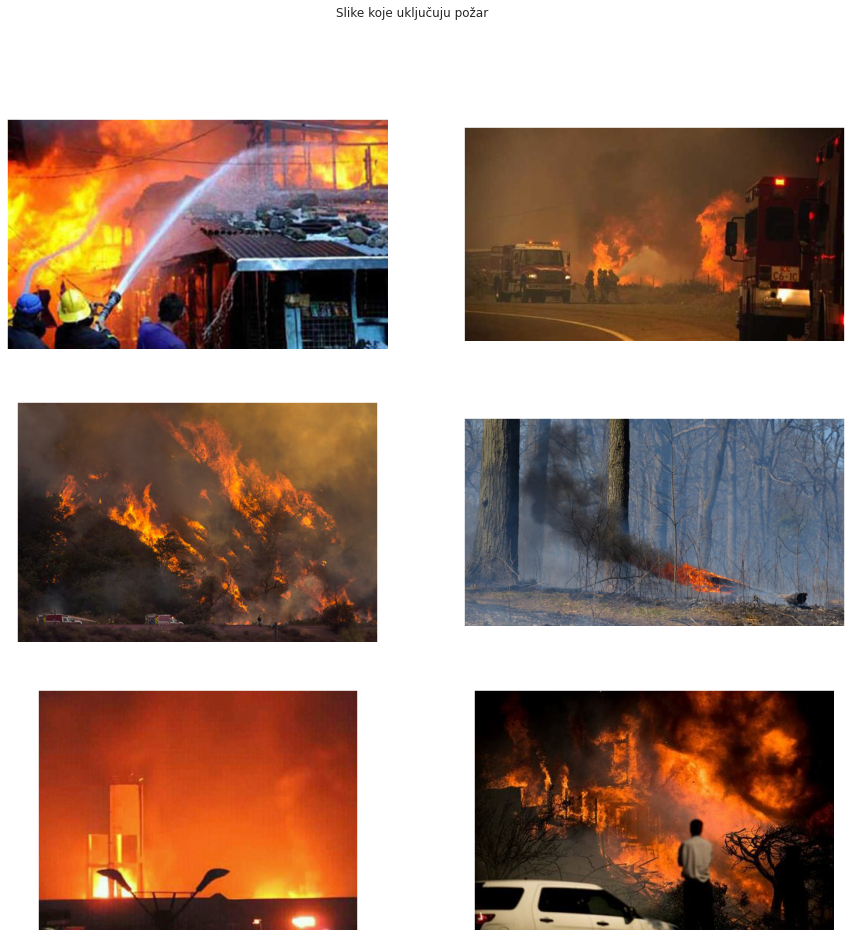

In [ ]:
label = 'fire' #Oznaka za slike za požarom
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #Broj slika
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Slike koje uključuju požar')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

Vizualizacija slika na kojima nema vatre:

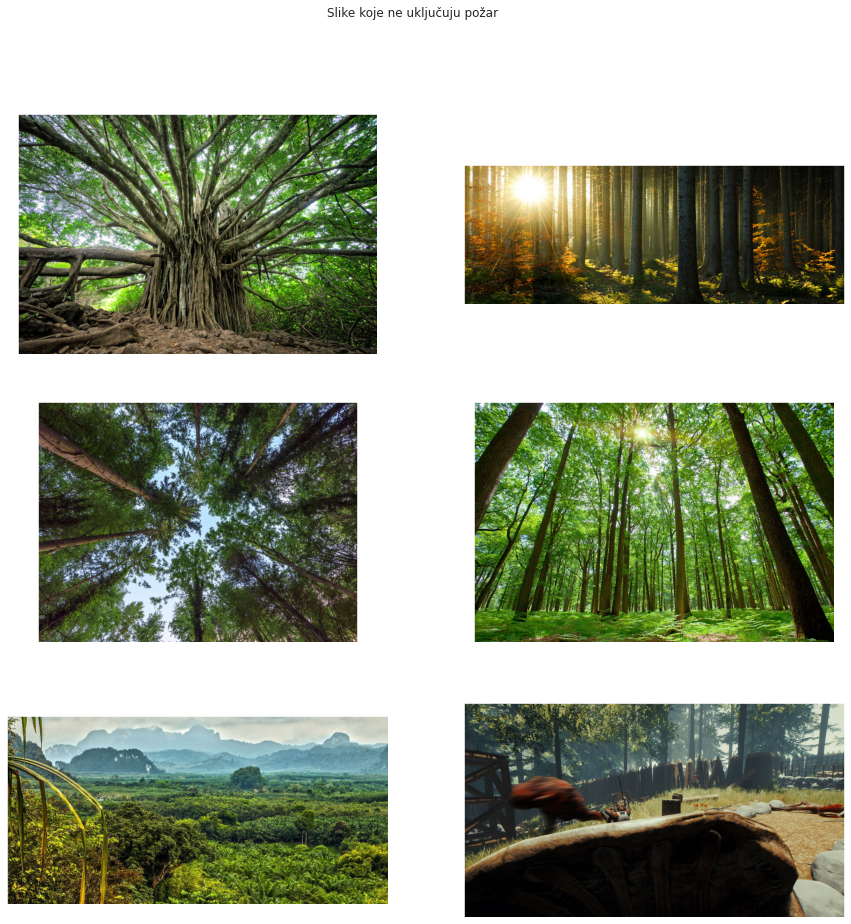

In [ ]:
label = 'non_fire' #oznaka za slike koje ne sadrže požar
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #Broj slika
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Slike koje ne uključuju požar')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

Primjetimo kako su prikazane slike drugačijih dimenzija.

In [ ]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

path     label  height  width
0  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire     983   1500
1  /content/drive/MyDrive/Strojno_projekt/fire_da...  non_fire    1200   1920
2  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire     360    640
3  /content/drive/MyDrive/Strojno_projekt/fire_da...  non_fire     850   1920
4  /content/drive/MyDrive/Strojno_projekt/fire_da...      fire    2024   3000

Prikaz distribucije oblika slika.

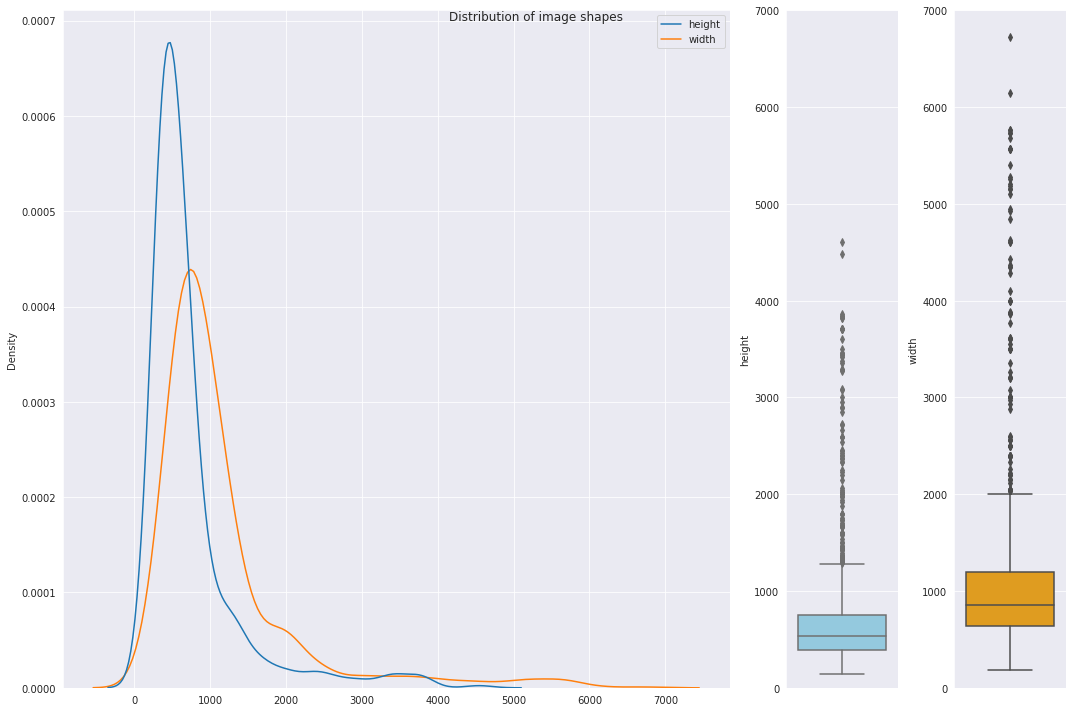

In [ ]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

Visina i širina slika previše variraju. Moramo ih preoblikovati u fiksni oblik prije treninga.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Izrada generatora za treniranje i testiranje

Koristit ćemo metodu flow_from_dataframe klase ImageDataGenerator. Preuzet će putanju slika iz podatkovnog okvira zajedno s njihovim oznakama. Konstruiramo dva generatora, jedan za obuku, a drugi za validaciju.

Napomena: Naše oznake su nizovi 'fire ' i 'non_fire'. Generator slika automatski će ih kodirati u cjelobrojne oznake.

In [ ]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [ ]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [ ]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


Slika koja sadrži vatru će sadržavati indeks 0, odnosno ukoliko ne sadrži vatru indeks 1.

Vizualiziranje generiranih slika u treniranom skupu:

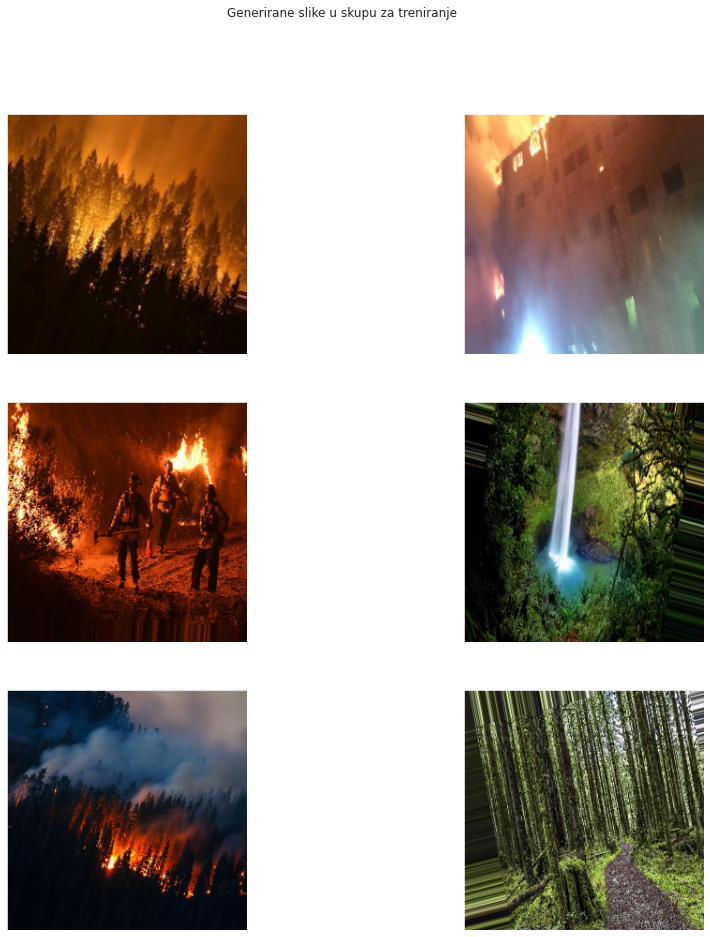

In [ ]:
sns.set_style('dark')
pics = 6 #Broj slika
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generirane slike u skupu za treniranje')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

<center>

# *Konvolucijske neuronske mreže(CNN)*

</center>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

Povećavamo broj filtara kako dodajemo više slojeva jer će u početku biti prisutno mnogo šuma u ulazu i trebamo uhvatiti samo važne informacije. Kasnije, kako napredujemo kroz slojeve, karte značajki postaju nijansirane i pokušavamo ih uhvatiti s više filtara

Model Summary:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

In [ ]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

Model Fitting:

In [ ]:
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
25/25 [==============================] - 57s 2s/step - loss: 0.3289 - accuracy: 0.8525 - recall: 0.6218 - auc: 0.8984 - val_loss: 0.2054 - val_accuracy: 0.9347 - val_recall: 0.7451 - val_auc: 0.9865 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 45s 2s/step - loss: 0.1352 - accuracy: 0.9388 - recall: 0.8497 - auc: 0.9831 - val_loss: 0.1426 - val_accuracy: 0.9497 - val_recall: 0.9412 - val_auc: 0.9861 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 45s 2s/step - loss: 0.1402 - accuracy: 0.9450 - recall: 0.8912 - auc: 0.9842 - val_loss: 0.1193 - val_accuracy: 0.9447 - val_recall: 0.8627 - val_auc: 0.9870 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 46s 2s/step - loss: 0.1114 - accuracy: 0.9488 - recall: 0.8601 - auc: 0.9903 - val_loss: 0.1160 - val_accuracy: 0.9548 - val_recall: 0.9412 - val_auc: 0.9919 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 45s 2s/step - loss: 0.0831 - accuracy: 0.9712 - recall: 

Evaluacija modela:

In [ ]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [ ]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 9s 1s/step - loss: 0.1125 - accuracy: 0.9497 - recall: 0.9020 - auc: 0.9897
loss: 0.11
accuracy: 0.95
recall: 0.90
auc: 0.99


Model kreiran pomoću Transfer Learning-a.

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [ ]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#Isključivanje treninga (zamrzavanje modela)
xception.trainable = False

#Kreiranje novog modela
x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

83683744/83683744 [==============================] - 4s 0us/step


Kompajliranje modela:

In [ ]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

Model Fitting:

In [ ]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=15,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/15
25/25 [==============================] - 53s 2s/step - loss: 0.9306 - accuracy: 0.8838 - recall_1: 0.7772 - auc_1: 0.9087 - val_loss: 0.2773 - val_accuracy: 0.9296 - val_recall_1: 0.9020 - val_auc_1: 0.9516 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 46s 2s/step - loss: 0.1255 - accuracy: 0.9575 - recall_1: 0.8808 - auc_1: 0.9858 - val_loss: 0.1775 - val_accuracy: 0.9497 - val_recall_1: 0.8627 - val_auc_1: 0.9834 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 46s 2s/step - loss: 0.0560 - accuracy: 0.9812 - recall_1: 0.9534 - auc_1: 0.9951 - val_loss: 0.1572 - val_accuracy: 0.9598 - val_recall_1: 0.9020 - val_auc_1: 0.9791 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 47s 2s/step - loss: 0.0952 - accuracy: 0.9725 - recall_1: 0.9326 - auc_1: 0.9928 - val_loss: 0.1559 - val_accuracy: 0.9548 - val_recall_1: 0.8627 - val_auc_1: 0.9732 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 46s 2s/step - loss: 0.06

Evaluacija modela:

In [ ]:
px.line(history,title='Metrics Plot')

In [ ]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 9s 1s/step - loss: 0.0953 - accuracy: 0.9548 - recall: 0.9020 - auc: 0.9929
loss: 0.10
accuracy: 0.95
recall: 0.90
auc: 0.99



<center>

# *Primjer*

</center>

Poslužimo se slikom stambenog kompleksa u Teksasu koji je zahvatio požar u veljači 2021.

*Izvor:  https://www.nytimes.com/2021/02/19/us/san-antonio-fire-hydrants-water.html*

In [ ]:
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50241  100 50241    0     0   981k      0 --:--:-- --:--:-- --:--:--  981k


Promjena veličine slike kako bi odgovarala ostalim dimenzijama u seriji.

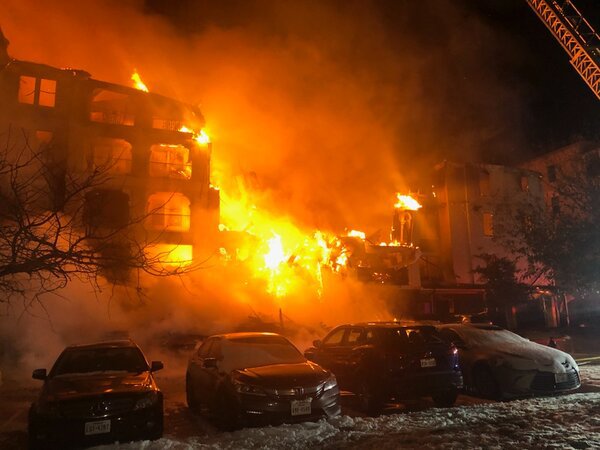

In [ ]:
#Učitavanje slike
img = image.load_img('predict.jpg')
img

In [ ]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


In [ ]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 1s 1s/step
The predicted value is:  0 and the predicted label is: fire


<center>

# *Primjer2*

</center>

*Izvor: https://www.24sata.hr/promo-sadrzaj/tom-hanks-u-ekranizaciji-svjetskog-bestselera-888469*

In [ ]:
!curl https://img.24sata.hr/PFEj8fs3TX-jLXCfmiqIayAyRxs=/1243x700/smart/media/images/2023-05/df-02870-r.jpg --output prediction.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75214  100 75214    0     0  38218      0  0:00:01  0:00:01 --:--:-- 38199


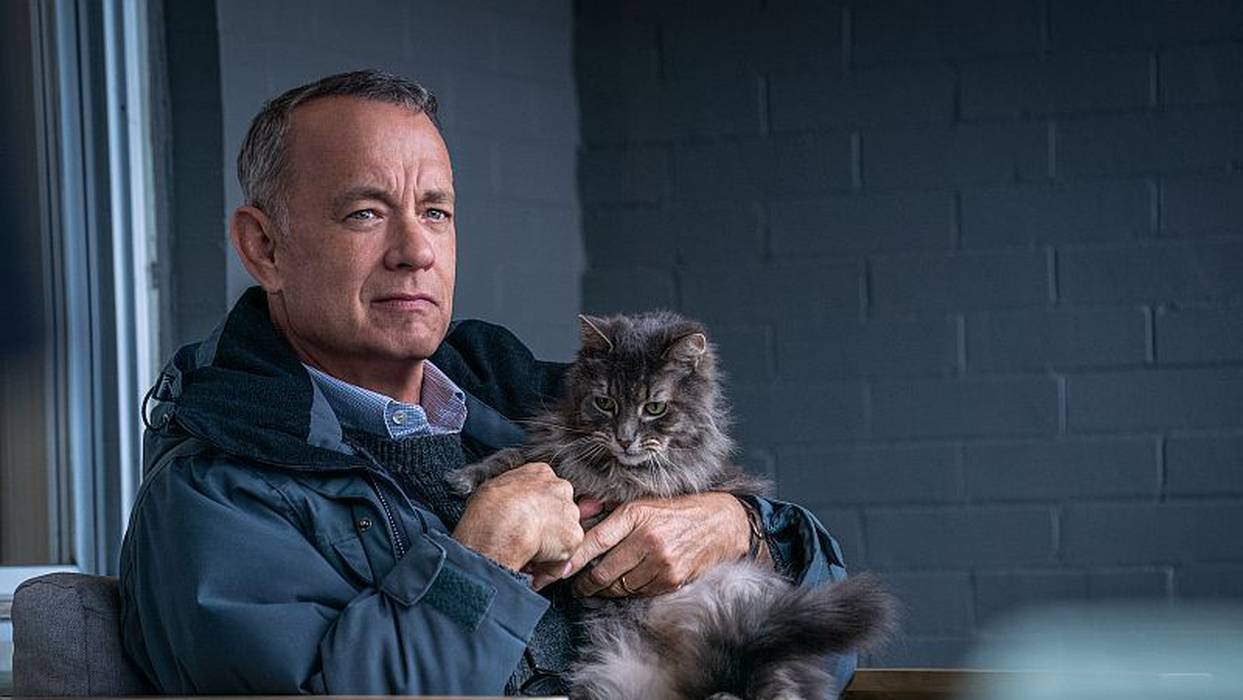

In [ ]:
#Učitavanje slike
img2 = image.load_img('prediction.jpg')
img2

In [ ]:
img2 = image.img_to_array(img2)/255
img2 = tf.image.resize(img2,(256,256))
img2 = tf.expand_dims(img2,axis=0)

print("Image Shape",img2.shape)

Image Shape (1, 256, 256, 3)


In [ ]:
prediction = int(tf.round(model2.predict(x=img2)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 0s 48ms/step
The predicted value is:  1 and the predicted label is: non_fire


<center>

# *Primjer3*

</center>

*Izvor: https://slobodnadalmacija.hr/split/nocna-buktinja-u-splitu-veliki-pozar-izbio-u-skladistu-automobilskih-guma-na-terenu-bilo-30-vatrogasaca-i-10-vozila-1255939#&gid=1&pid=2*

In [ ]:
!curl https://static.slobodnadalmacija.hr/images/slike/2023/01/12/o_24124964_1280.jpg --output prediction2.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  278k  100  278k    0     0   204k      0  0:00:01  0:00:01 --:--:--  204k


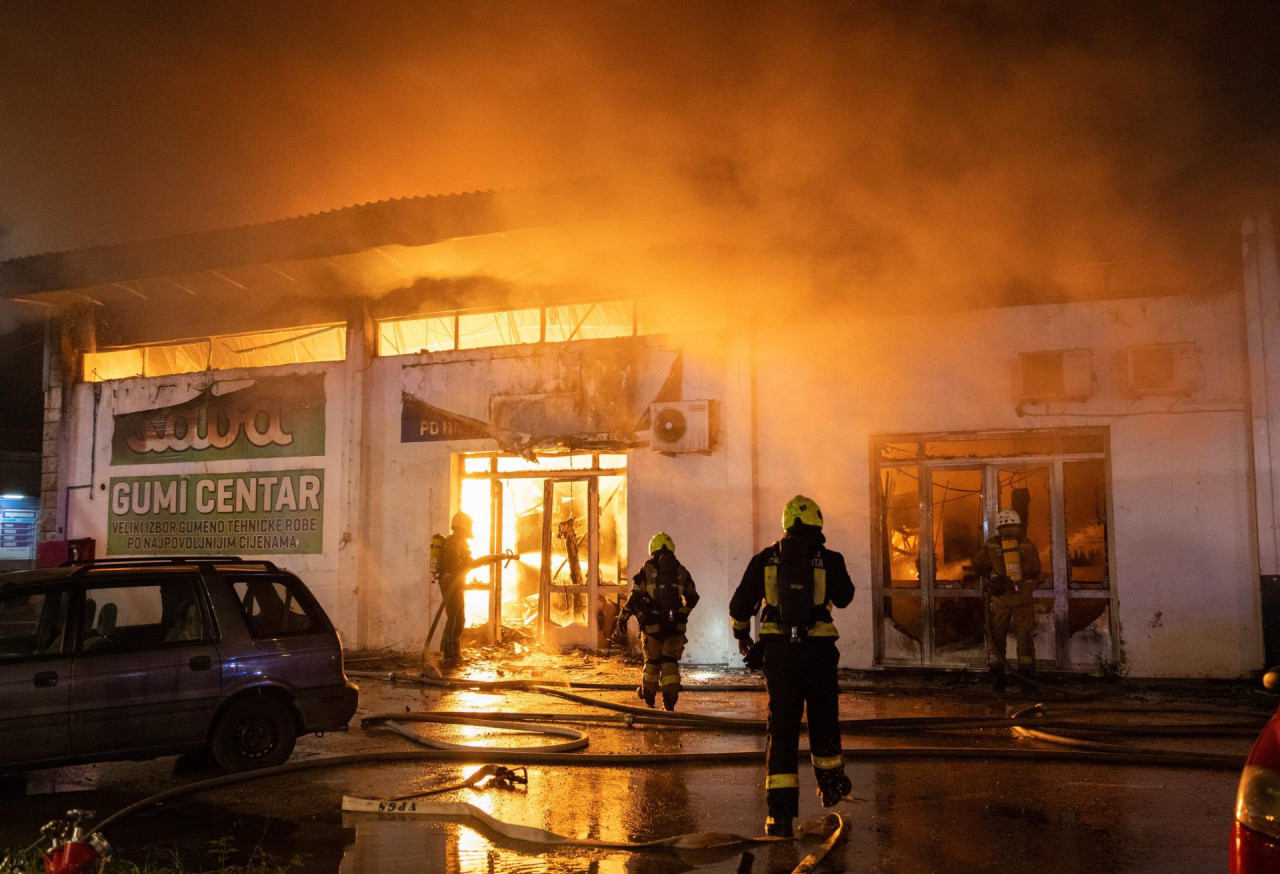

In [ ]:
#Učitavanje slike
img3 = image.load_img('prediction2.jpg')
img3

In [ ]:
img3 = image.img_to_array(img3)/255
img3 = tf.image.resize(img3,(256,256))
img3 = tf.expand_dims(img3,axis=0)

print("Image Shape",img3.shape)

Image Shape (1, 256, 256, 3)


In [ ]:
prediction = int(tf.round(model2.predict(x=img3)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 0s 30ms/step
The predicted value is:  0 and the predicted label is: fire


<center>

# *Zaključak*

</center>

Iz prethodno navedenih primjera, uz pomoć Transfer Learning-a, možemo uočiti kako je algoritam na temelju prethodnih slika sa požarom i slika bez požara klasificirao sliku koju smo izabrali nasumično kao vrijednost 0, vrijednost koja predstavlja požar, odnosno vrijednost 1, vrijednost koja ne predstavlja požar. Samim time ostvarili smo cilj ovog projekta.